# Variational Autoencoder

### Setup
Loading auxiliary files and importing the necessary libraries.

In [ ]:
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False
if IN_COLAB:
    print("Downloading Colab files")
    ! shred -u setup_google_colab.py
    ! wget https://raw.githubusercontent.com/hse-aml/bayesian-methods-for-ml/master/setup_google_colab.py -O setup_google_colab.py
    import setup_google_colab
    setup_google_colab.load_data_week5()

shred: setup_google_colab.py: failed to open for writing: No such file or directory
--2020-08-21 06:04:50--  https://raw.githubusercontent.com/hse-aml/bayesian-methods-for-ml/master/setup_google_colab.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1232 (1.2K) [text/plain]
Saving to: ‘setup_google_colab.py’

setup_google_colab. 100%[===================>]   1.20K  --.-KB/s    in 0s      

2020-08-21 06:04:50 (60.0 MB/s) - ‘setup_google_colab.py’ saved [1232/1232]

https://raw.githubusercontent.com/hse-aml/bayesian-methods-for-ml/master/week5/w5_grader.py w5_grader.py
https://raw.githubusercontent.com/hse-aml/bayesian-methods-for-ml/master/week5/test_data.npz test_data.npz


In [ ]:
%tensorflow_version 1.x
import tensorflow as tf
import keras
import numpy as np
import matplotlib.pyplot as plt

from keras.layers import Input, Dense, Lambda, InputLayer, concatenate,Conv2D, Conv2DTranspose,Flatten,Reshape,Concatenate
from keras.models import Model, Sequential
from keras import backend as K
from keras import metrics
from keras.datasets import mnist
from keras.utils import np_utils

### Variational Autoencoder

Variational Autoencoder is a probabilistic model of data based on a continious mixture of distributions. Here we will apply VAE to binary MNIST images (each pixel is either black or white). To better model binary data we will use a continuous mixture of binomial distributions: $p(x \mid w) = \int p(x \mid t, w) p(t) dt$, where the prior distribution on the latent code $t$ is standard normal $p(t) = \mathcal{N}(0, I)$, but probability that $(i, j)$-th pixel is black equals to $(i, j)$-th output of the decoder neural detwork: $p(x_{i, j} \mid t, w) = \text{decoder}(t, w)_{i, j}$.

To train this model we would like to maximize marginal log-likelihood of our dataset $\max_w \log p(X \mid w)$, but it's very hard to do computationally, so instead we maximize the Variational Lower Bound w.r.t. both the original parameters $w$ and variational distribution $q$ which we define as encoder neural network with parameters $\phi$ which takes input image $x$ and outputs parameters of the gaussian distribution $q(t \mid x, \phi)$: $\log p(X \mid w) \geq \mathcal{L}(w, \phi) \rightarrow \max_{w, \phi}$.

So overall our model looks as follows: encoder takes an image $x$, produces a distribution over latent codes $q(t \mid x)$ which should approximate the posterior distribution $p(t \mid x)$ (at least after training), samples a point from this distribution $\widehat{t} \sim q(t \mid x, \phi)$, and finally feeds it into a decoder that outputs a distribution over images.

![](https://github.com/hse-aml/bayesian-methods-for-ml/blob/master/week5/VAE.png?raw=1)

Since the variational lower bound has an expected value inside which we are going to approximate with sampling. But it is not trivial since we need to differentiate through this approximation. The _reparametrization trick_ offers a workaround for this issue as it allows us to sample from a distribution which doesn't depend on any parameters, e.g. standard normal, and then deterministically transform this sample to the desired one: $\varepsilon \sim \mathcal{N}(0, I); ~~\widehat{t} = m(x, \phi) + \varepsilon \sigma(x, \phi)$. This way we don't have to worry about our stochastic gradient being biased and can straightforwardly differentiate our loss w.r.t. all the parameters while treating the current sample $\varepsilon$ as constant.



### Negative Variational Lower Bound

In [ ]:
def vlb_binomial(x, x_decoded_mean, t_mean, t_log_var):
    """Returns the value of negative Variational Lower Bound
    
    The inputs are tf.Tensor
        x: (batch_size x number_of_pixels) matrix with one image per row with zeros and ones
        x_decoded_mean: (batch_size x number_of_pixels) mean of the distribution p(x | t), real numbers from 0 to 1
        t_mean: (batch_size x latent_dim) mean vector of the (normal) distribution q(t | x)
        t_log_var: (batch_size x latent_dim) logarithm of the variance vector of the (normal) distribution q(t | x)
    
    Returns:
        A tf.Tensor with one element (averaged across the batch), VLB
    """
    ### YOUR CODE HERE
    #Computing the KL divergence
    kl_loss=1/2*(1+t_log_var-tf.square(t_mean)-tf.exp(t_log_var))
    #
    kl_loss=tf.reduce_sum(kl_loss,axis=1)
    reconstruction_loss=x*tf.log(1e-10+x_decoded_mean)+(1-x)*tf.log(1e-10+1-x_decoded_mean)
    reconstruction_loss=tf.reduce_sum(reconstruction_loss,axis=1)
    loss=-tf.reduce_mean(kl_loss+reconstruction_loss)
    return loss 


## Encoder / decoder definition

**Task 2** The code below defines the encoder and decoder networks and implement sampling with reparametrization trick.

In [ ]:
batch_size = 100
original_dim = 784 # Number of pixels in MNIST images.
latent_dim = 10 # d, dimensionality of the latent code t.
intermediate_dim = 256 # Size of the hidden layer.
epochs = 15


x = Input(batch_shape=(batch_size,original_dim))

def create_encoder(input_dim):
    # Encoder network.
    # We instantiate these layers separately so as to reuse them later
    s=int(original_dim**(1/2))
    encoder = Sequential(name='encoder')
    encoder.add(InputLayer([original_dim]))
    encoder.add(Reshape((s,s,1)))
    encoder.add(Conv2D(filters=32, kernel_size=(3,3), strides=(1, 1),
    padding='same',activation="relu",input_shape=(s,s,1)))
    encoder.add(Flatten())
    encoder.add(Dense(intermediate_dim, activation='relu'))
    encoder.add(Dense(2 * latent_dim))
    return encoder
encoder = create_encoder(original_dim)


get_t_mean = Lambda(lambda h: h[:, :latent_dim])
get_t_log_var = Lambda(lambda h: h[:, latent_dim:])
h = encoder(x)
t_mean = get_t_mean(h)
t_log_var = get_t_log_var(h)

# Sampling from the distribution 
#     q(t | x) = N(t_mean, exp(t_log_var))
# with reparametrization trick.
def sampling(args):
    """Returns sample from a distribution N(args[0], diag(args[1]))
    
    The sample should be computed with reparametrization trick.
    
    The inputs are tf.Tensor
        args[0]: (batch_size x latent_dim) mean of the desired distribution
        args[1]: (batch_size x latent_dim) logarithm of the variance vector of the desired distribution
    
    Returns:
        A tf.Tensor of size (batch_size x latent_dim), the samples.
    """
    t_mean, t_log_var = args
    # YOUR CODE HERE
    eps=tf.random_normal(tf.shape(t_mean),mean=0.0,stddev=1.0,seed=5)
    t=eps*tf.exp(0.5*t_log_var)+t_mean
    return t


t = Lambda(sampling)([t_mean, t_log_var])

def create_decoder(input_dim):
    w=int((intermediate_dim)**(1/2))
    decoder = Sequential(name='decoder')
    decoder.add(InputLayer([input_dim]))
    decoder.add(Dense(intermediate_dim, input_shape=([input_dim]),activation='relu'))
    decoder.add(Reshape((w,w,1)))
    decoder.add(Conv2DTranspose(filters=32, kernel_size=(3,3), strides=(1, 1),
      padding='same',activation="relu",input_shape=(w,w,1)))
    decoder.add(Flatten())
    decoder.add(Dense(28**2,activation="sigmoid"))
    
    return decoder
decoder = create_decoder(latent_dim)
x_decoded_mean = decoder(t)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


## Training the model

In [ ]:
loss = vlb_binomial(x, x_decoded_mean, t_mean, t_log_var)
vae = Model(x, x_decoded_mean)
# Keras will provide input (x) and output (x_decoded_mean) to the function that
# should construct loss, but since our function also depends on other
# things (e.g. t_means), it is easier to build the loss in advance and pass
# a function that always returns it.
vae.compile(optimizer=keras.optimizers.RMSprop(lr=0.001), loss=lambda x, y: loss)

#### Load and prepare the data

In [ ]:
# train the VAE on MNIST digits
(x_train, y_train), (x_test, y_test) = mnist.load_data()
# One hot encoding.
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

11493376/11490434 [==============================] - 2s 0us/step


#### Train the model

In [ ]:
hist = vae.fit(x=x_train, y=x_train,
               shuffle=True,
               epochs=epochs,
               batch_size=batch_size,
               validation_data=(x_test, x_test),
               verbose=2)


Train on 60000 samples, validate on 10000 samples
Epoch 1/15
 - 20s - loss: 140.9072 - val_loss: 120.7565
Epoch 2/15
 - 14s - loss: 115.5454 - val_loss: 111.1701
Epoch 3/15
 - 14s - loss: 110.5970 - val_loss: 108.4875
Epoch 4/15
 - 14s - loss: 108.1683 - val_loss: 107.0013
Epoch 5/15
 - 14s - loss: 106.5963 - val_loss: 106.1284
Epoch 6/15
 - 14s - loss: 105.4220 - val_loss: 106.1362
Epoch 7/15
 - 14s - loss: 104.5449 - val_loss: 104.6084
Epoch 8/15
 - 14s - loss: 103.8029 - val_loss: 104.9888
Epoch 9/15
 - 14s - loss: 103.1794 - val_loss: 104.5868
Epoch 10/15
 - 14s - loss: 102.6544 - val_loss: 104.2951
Epoch 11/15
 - 14s - loss: 102.2097 - val_loss: 104.0916
Epoch 12/15
 - 14s - loss: 101.7969 - val_loss: 103.9121
Epoch 13/15
 - 14s - loss: 101.4600 - val_loss: 103.8791
Epoch 14/15
 - 14s - loss: 101.0857 - val_loss: 103.4128
Epoch 15/15
 - 14s - loss: 100.8240 - val_loss: 103.7480


### Visualize reconstructions for train and validation data
As shown in the pictures below, the reconstruction ability of the network on training and validation data has been relatively satisfactory. In each of the two images, the left column is MNIST images and the right column is the corresponding image after passing through autoencoder (or more precisely the mean of the binomial distribution over the output images).

Note that getting the best possible reconstruction is not the point of VAE, the KL term of the objective specifically hurts the reconstruction performance. But the reconstruction should be anyway reasonable and they provide a visual debugging tool.

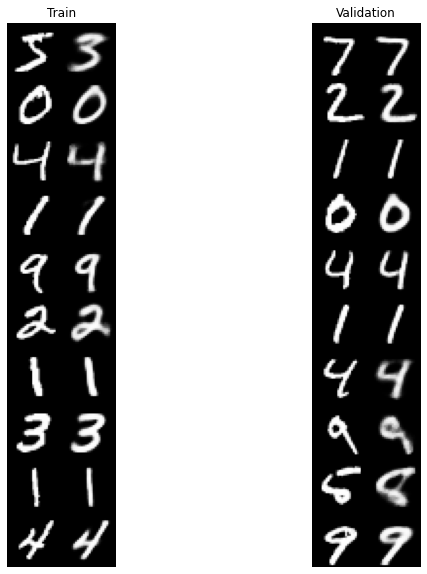

In [ ]:
fig = plt.figure(figsize=(10, 10))
for fid_idx, (data, title) in enumerate(
            zip([x_train, x_test], ['Train', 'Validation'])):
    n = 10  # figure with 10 x 2 digits
    digit_size = 28
    figure = np.zeros((digit_size * n, digit_size * 2))
    decoded = sess.run(x_decoded_mean, feed_dict={x: data[:batch_size, :]})
    for i in range(10):
        figure[i * digit_size: (i + 1) * digit_size,
               :digit_size] = data[i, :].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               digit_size:] = decoded[i, :].reshape(digit_size, digit_size)
    ax = fig.add_subplot(1, 2, fid_idx + 1)
    ax.imshow(figure, cmap='Greys_r')
    ax.set_title(title)
    ax.axis('off')
plt.show()

## Hallucinating new data
The code below generates new samples of images from your trained VAE by sampling from the prior distribution $p(t)$ and then from the likelihood $p(x \mid t)$.


In [ ]:
n_samples = 10
t_new=tf.random_normal([10,latent_dim],mean=0.0,stddev=1.0,seed=4)
sampled_im_mean=decoder(t_new)

In [ ]:
sampled_im_mean_np=sampled_im_mean.eval()

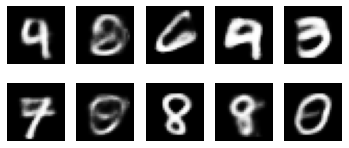

In [ ]:
sampled_im_mean_np = sess.run(sampled_im_mean)
# Show the sampled images.
plt.figure()
for i in range(n_samples):
    ax = plt.subplot(n_samples // 5 + 1, 5, i + 1)
    plt.imshow(sampled_im_mean_np[i, :].reshape(28, 28), cmap='gray')
    ax.axis('off')
plt.show()

# Conditional VAE

In the final section, we will implement a Conditional Variational Autoencoder [1]. The idea is very simple: to be able to control the samples you generate, we condition all the distributions on some additional information. In our case, this additional information will be the class label (the digit on the image, from 0 to 9).

![](https://github.com/hse-aml/bayesian-methods-for-ml/blob/master/week5/CVAE.png?raw=1)

So now both the likelihood and the variational distributions are conditioned on the class label: $p(x \mid t, \text{label}, w)$, $q(t \mid x, \text{label}, \phi)$.

The only thing we need to modify is to concatenate input image $x$ with (one-hot) label of this image to pass into the encoder $q$ and to concatenate latent code $t$ with the same label to pass into the decoder $p$. 

[1] Sohn, Kihyuk, Honglak Lee, and Xinchen Yan. “Learning Structured Output Representation using Deep Conditional Generative Models.” Advances in Neural Information Processing Systems. 2015.

## Final task

**Task 5.1** Implement CVAE model. You may reuse ```create_encoder``` and ```create_decoder``` modules defined previously (now you can see why they accept the input size as an argument ;) ). You may also need `concatenate` Keras layer to concatenate labels with input data and latent code.

To finish this task, you should go to `Conditionally hallucinate data` section and find there Task 5.2

In [ ]:
# One-hot labels placeholder.
x = Input(batch_shape=(batch_size, original_dim))
label = Input(batch_shape=(batch_size, 10))


def create_encoder(input_dim):
    # Encoder network.
    # We instantiate these layers separately so as to reuse them later
    s=int(intermediate_dim**(1/2))
    encoder = Sequential(name='encoder')
    encoder.add(InputLayer([original_dim+10]))
    encoder.add(Dense(intermediate_dim, activation='relu'))
    encoder.add(Reshape((s,s,1)))
    encoder.add(Conv2D(filters=32, kernel_size=(3,3), strides=(1, 1),
    padding='same',activation="relu",input_shape=(s,s,1)))
    encoder.add(Flatten())
    encoder.add(Dense(2 * latent_dim))
    return encoder
encoder = create_encoder(original_dim+10)
inp=concatenate([x,label])
h=encoder(inp)


cond_t_mean =  get_t_mean(h)# Mean of the latent code (without label) for cvae model.
cond_t_log_var =get_t_log_var(h) # Logarithm of the variance of the latent code (without label) for cvae model.
t = Lambda(sampling)([cond_t_mean, cond_t_log_var])
inp_de=concatenate([t,label])
decoder=create_decoder(latent_dim+10)
cond_x_decoded_mean = decoder(inp_de) # Final output of the cvae model.

In [ ]:
def create_decoder(input_dim):
    w=int((intermediate_dim)**(1/2))
    decoder = Sequential(name='decoder')
    decoder.add(InputLayer([input_dim]))
    decoder.add(Dense(intermediate_dim, input_shape=([input_dim]),activation='relu'))
    decoder.add(Reshape((w,w,1)))
    decoder.add(Conv2DTranspose(filters=32, kernel_size=(3,3), strides=(1, 1),
      padding='same',activation="relu",input_shape=(w,w,1)))
    decoder.add(Flatten())
    decoder.add(Dense(28**2,activation="sigmoid"))
    
    return decoder

In [ ]:
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_40 (Dense)             (None, 256)               5376      
_________________________________________________________________
reshape_20 (Reshape)         (None, 16, 16, 1)         0         
_________________________________________________________________
conv2d_transpose_10 (Conv2DT (None, 16, 16, 32)        320       
_________________________________________________________________
flatten_20 (Flatten)         (None, 8192)              0         
_________________________________________________________________
dense_41 (Dense)             (None, 784)               6423312   
Total params: 6,429,008
Trainable params: 6,429,008
Non-trainable params: 0
_________________________________________________________________


## Define the loss and the model

In [ ]:
cvae = Model([x,label], cond_x_decoded_mean)

In [ ]:
conditional_loss = vlb_binomial(x, cond_x_decoded_mean, cond_t_mean, cond_t_log_var)
cvae = Model([x,label], cond_x_decoded_mean)
cvae.compile(optimizer=keras.optimizers.RMSprop(lr=0.001), loss=lambda x, y: conditional_loss)

### Train the model

In [ ]:
hist = cvae.fit(x=[x_train, y_train],
                y=x_train,
                shuffle=True,
                epochs=epochs,
                batch_size=batch_size,
                validation_data=([x_test, y_test], x_test),
                verbose=2)

Train on 60000 samples, validate on 10000 samples
Epoch 1/15
 - 9s - loss: 142.6583 - val_loss: 118.2543
Epoch 2/15
 - 9s - loss: 115.5385 - val_loss: 110.7906
Epoch 3/15
 - 9s - loss: 109.6903 - val_loss: 107.2415
Epoch 4/15
 - 9s - loss: 106.6191 - val_loss: 106.0392
Epoch 5/15
 - 9s - loss: 104.6581 - val_loss: 104.4987
Epoch 6/15
 - 9s - loss: 103.2426 - val_loss: 103.5120
Epoch 7/15
 - 9s - loss: 102.1212 - val_loss: 102.4929
Epoch 8/15
 - 9s - loss: 101.2160 - val_loss: 101.1979
Epoch 9/15
 - 9s - loss: 100.4928 - val_loss: 101.5898
Epoch 10/15
 - 9s - loss: 99.8335 - val_loss: 100.1101
Epoch 11/15
 - 9s - loss: 99.3010 - val_loss: 100.4757
Epoch 12/15
 - 9s - loss: 98.8365 - val_loss: 99.8770
Epoch 13/15
 - 9s - loss: 98.3969 - val_loss: 99.4446
Epoch 14/15
 - 9s - loss: 98.0303 - val_loss: 99.0691
Epoch 15/15
 - 9s - loss: 97.6945 - val_loss: 99.8100


### Visualize reconstructions for train and validation data

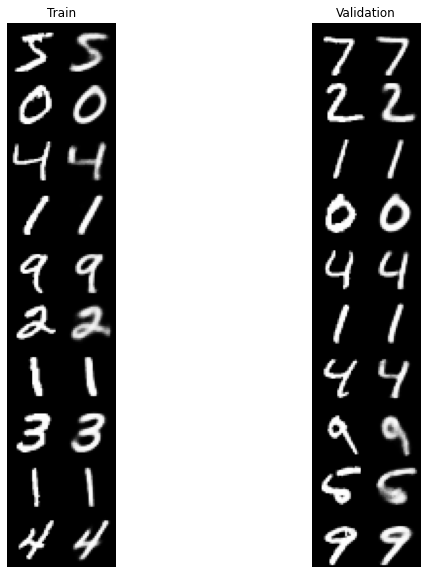

In [ ]:
fig = plt.figure(figsize=(10, 10))
for fid_idx, (x_data, y_data, title) in enumerate(
            zip([x_train, x_test], [y_train, y_test], ['Train', 'Validation'])):
    n = 10  # figure with 10 x 2 digits
    digit_size = 28
    figure = np.zeros((digit_size * n, digit_size * 2))
    decoded = sess.run(cond_x_decoded_mean,
                       feed_dict={x: x_data[:batch_size, :],
                                  label: y_data[:batch_size, :]})
    for i in range(10):
        figure[i * digit_size: (i + 1) * digit_size,
               :digit_size] = x_data[i, :].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               digit_size:] = decoded[i, :].reshape(digit_size, digit_size)
    ax = fig.add_subplot(1, 2, fid_idx + 1)
    ax.imshow(figure, cmap='Greys_r')
    ax.set_title(title)
    ax.axis('off')
plt.show()

## Conditionally hallucinate data
**Task 5.2** Implement the conditional sampling from the distribution $p(x \mid t, \text{label})$ by firstly sampling from the prior $p(t)$ and then sampling from the likelihood $p(x \mid t, \text{label})$.

In [ ]:
curr_labels = tf.eye(10)
curr_labels = tf.repeat(curr_labels, 5, axis=0) 

In [ ]:
t_con_new=tf.random_normal((50,latent_dim),)

In [ ]:
input_con_new=concatenate([t_con_new,curr_labels])

In [ ]:
cond_sampled_im_mean =decoder(input_con_new)

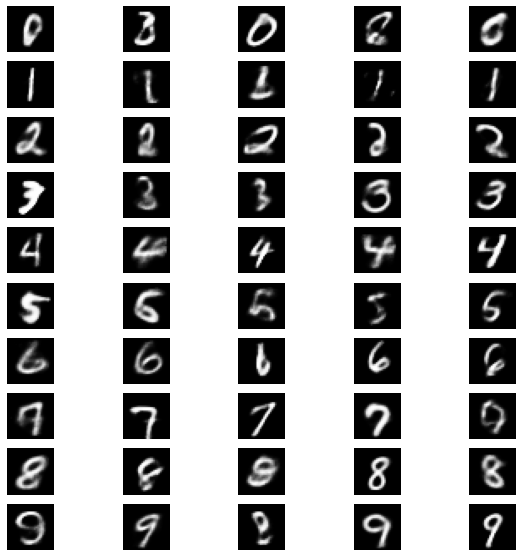

In [ ]:
cond_sampled_im_mean_np = sess.run(cond_sampled_im_mean)
# Show the sampled images.
plt.figure(figsize=(10, 10))
global_idx = 0
for digit in range(10):
    for _ in range(5):
        ax = plt.subplot(10, 5, global_idx + 1)
        plt.imshow(cond_sampled_im_mean_np[global_idx, :].reshape(28, 28), cmap='gray')
        ax.axis('off')
        global_idx += 1
plt.show()